## Imports

In [2]:
import os
import gc
import time
import json
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
from tqdm import tqdm
from datetime import datetime
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader
from torch.amp import GradScaler  # Updated GradScaler import

# PyTorch utilities
from pytorch_utils.training_utils import *
import pytorch_utils.training_utils as pt_train

# Hyperparameter tuning
from hyperopt import hp, STATUS_OK, fmin, tpe, space_eval, Trials
from hyperopt.pyll import scope

# Captum for interpretability
from captum.attr import Saliency
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

# TorchMetrics
from torchmetrics import ConfusionMatrix

# Get default Matplotlib backend
default_matplotlib_backend = matplotlib.get_backend()
print("Imported")
print(f"Default Matplotlib backend: {default_matplotlib_backend}")

Imported
Default Matplotlib backend: module://matplotlib_inline.backend_inline


## Constants

In [5]:
RUN_MODE = ['DEV','LIVE'][1]

SIMPLE_PATH = False  # Set this to false if you want to use custom paths

# Ensure consistent data distribution across different machines
np.random.seed(42)

# Determine if the operating system is Windows
windows = (os.name == 'nt')

# Define whether to use a simple path structure
SIMPLE_PATH = True  # Set this variable to True or False
RUN_MODE = "DEV"  # Change as needed (DEV or PROD)

# Define root path based on the operating system
if windows or SIMPLE_PATH:
    root_path = os.getcwd()  # Root project folder
    extracted_data_path = os.path.join(root_path, "datasets", "dataset_4a_n_crop")
    weights_path = os.path.join(root_path, "weights")
    stats_path = os.path.join(root_path, "stats")
    npy_data_path = os.path.join(root_path, "npy_data")
    model_save_path = os.path.join(root_path, "model")
else:
    root_path = None
    extracted_data_path = None
    weights_path = None
    stats_path = None
    npy_data_path = None
    model_save_path = None

# Create directories if they do not exist (only if paths are valid)
def create_directory_if_not_exists(directory):
    if directory and not os.path.exists(directory):
        os.makedirs(directory)

if npy_data_path:
    create_directory_if_not_exists(npy_data_path)
    create_directory_if_not_exists(weights_path)
    create_directory_if_not_exists(stats_path)
    create_directory_if_not_exists(model_save_path)

# Get the list of classes (only if extracted_data_path is valid)
if extracted_data_path and os.path.exists(extracted_data_path):
    class_list = os.listdir(extracted_data_path)[:3] if RUN_MODE == "DEV" else os.listdir(extracted_data_path)
    class_list.sort()
    print('Number of classes: {}'.format(len(class_list)))
else:
    class_list = []
    print("Warning: Extracted data path is not set or does not exist.")

# Determine the working device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Selected device: {}'.format(device))
if device.type == 'cuda':
    print('Device name: {}'.format(torch.cuda.get_device_name(device)))

# Define other constants
BATCH_SIZE = 16 if RUN_MODE == "DEV" else 64
EPOCHS = 3 if RUN_MODE == "DEV" else 30
IMG_SIZE = (350, 350)
RESIZE_SHAPE = (350, 350)
NUM_CHANNELS = 3
BACKBONE = 'ResNet18'
OPTIMIZER = 'SGD'

# Available backbones and optimizers
available_backbones = [
    'AlexNet', 'ResNet18', 'ResNet34', 'ResNet101', 'InceptionNet', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2',
    'EfficientNetV2_S', 'ConvNext_T', 'MobileNet_V3_Small', 'MobileNet_V3_Large', 'ViT_B_16'
]
available_optimizers = ['SGD', 'Adam', 'AdamW', 'RMSprop']

# Assert the chosen backbone and optimizer are available
assert BACKBONE in available_backbones, 'Choose an available backbone'
assert OPTIMIZER in available_optimizers, 'Choose an available optimizer'

Number of classes: 0
Selected device: cuda
Device name: NVIDIA RTX A6000


## Data loading  

In [16]:
# Specify which subdataset to use
DATASET_GROUP_IDX = None  # Could be: None, 0, 1, 2
train_valid_test_split_json_name = 'NEW25split.json'

# Define dataset paths based on the chosen JSON file
if train_valid_test_split_json_name == 'NEW8split.json':
    dataset_path = "/mnt/medaghub-ws/Rick/CR_datasets/dataset_3n_a_auto_cropped/"
elif train_valid_test_split_json_name == 'NEW25split.json':
    dataset_path = "/mnt/medaghub-ws/Rick/CR_datasets/dataset_4a_n_auto_cropped/"
else:
    raise ValueError(f"Unknown JSON file: {train_valid_test_split_json_name}")

# Update extracted_data_path accordingly
extracted_data_path = dataset_path


# Available subdatasets
indep1 = [18, 9, 26, 29, 34]
dataset_groups = [
    [1, 7, 10, 14, 11, 32, 13, 4, 8, 17, 20, 25, 28, 31, 36],
    [0, 15, 21, 22, 23, 5],
    [37, 33, 16, 2, 3, 6, 12, 19, 24, 27, 30, 35] + indep1,
]

# Print number of classes
class_list = os.listdir(extracted_data_path)
class_list.sort()
print('Number of classes: {}'.format(len(class_list)))

# Loading data
print('Loading data ...')
image_files = []
targets = []

# Dictionary to map class_name to class_index
class_dict = {class_name: i for i, class_name in enumerate(class_list)}

# Load all image_paths
for class_name in class_dict.keys():
    repetitions_list = os.listdir(os.path.join(extracted_data_path, class_name))
    repetitions_list.sort()
    for repetition in repetitions_list:
        image_list = os.listdir(os.path.join(extracted_data_path, class_name, repetition))
        image_list.sort()
        image_files.extend(
            [os.path.join(extracted_data_path, class_name, repetition, img) for img in image_list]
        )
        targets.extend([class_dict[class_name]] * len(image_list))

targets = np.array(targets)

# Save data as .npy files if they do not exist
if not os.path.exists(os.path.join(npy_data_path, 'images.npy')):
    print('Saving data as .npy files to {}'.format(npy_data_path))
    images = np.empty((len(image_files), NUM_CHANNELS, 350, 350), dtype=np.uint8)
    for idx, img_path in enumerate(tqdm(image_files, position=0, leave=True)):
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (350, 350))
        img = img.transpose(2, 0, 1)
        images[idx] = img

    with open(os.path.join(npy_data_path, 'images.npy'), 'wb') as npy_images_file, \
         open(os.path.join(npy_data_path, 'targets.npy'), 'wb') as npy_targets_file:
        np.save(npy_images_file, images, allow_pickle=True)
        np.save(npy_targets_file, targets, allow_pickle=True)
    with open(os.path.join(npy_data_path, 'image_files.json'), 'w') as f:
        json.dump(image_files, f)
    print('Data files saved')
else:
    images = np.load(os.path.join(npy_data_path, 'images.npy'))
    targets = np.load(os.path.join(npy_data_path, 'targets.npy'))
    print('Data files loaded')

# Apply train/valid/test split from JSON
with open(os.path.join(root_path, train_valid_test_split_json_name), 'r') as f:
    image_files_dict_cut = json.load(f)

classes_to_use = sorted(list(image_files_dict_cut.keys()))
mapper_allcls_to_subcls = {class_dict[cls_name]: i for i, cls_name in enumerate(classes_to_use)}
class_dict = {cls_name: i for i, cls_name in enumerate(classes_to_use)}
class_list = [cls_name for i, cls_name in enumerate(classes_to_use)]

new_targets = []
new_image_files = []
for t, im in zip(targets, image_files):
    if t in mapper_allcls_to_subcls:
        new_targets.append(mapper_allcls_to_subcls[t])
        new_image_files.append(im)
new_targets = np.array(new_targets)
targets = new_targets
image_files = new_image_files

train_images_idxs, val_images_idxs, test_images_idxs = [], [], []

# Split images into train, validation, and test sets
for image_file_idx, image_file_name in enumerate(image_files):
    image = images[image_file_idx]
    target = targets[image_file_idx]

    _class, rep_num, im_name = image_file_name.split(os.sep)[-3:]
    
    if (_class not in image_files_dict_cut) or (rep_num not in image_files_dict_cut[_class]):
        continue
    if image_files_dict_cut[_class][rep_num] == 'train':
        train_images_idxs.append(image_file_idx)
    elif image_files_dict_cut[_class][rep_num] == 'valid':
        val_images_idxs.append(image_file_idx)
    elif image_files_dict_cut[_class][rep_num] == 'test':
        test_images_idxs.append(image_file_idx)

train_images = images[train_images_idxs]
train_images = images[train_images_idxs]
val_images   = images[val_images_idxs]
test_images  = images[test_images_idxs]

train_targets = targets[train_images_idxs]
val_targets   = targets[val_images_idxs]
test_targets  = targets[test_images_idxs]

# Assertions to check the lengths
assert len(train_images) == len(train_targets)
assert len(test_images) == len(test_targets)
assert len(val_images) == len(val_targets)

# Print the number of images in each set
print('Number of training images: {}'.format(len(train_images)))
print('Number of test images: {}'.format(len(test_images)))
print('Number of validation images: {}'.format(len(val_images)))

Number of classes: 25
Loading data ...
Data files loaded
Number of training images: 5272
Number of test images: 1096
Number of validation images: 774


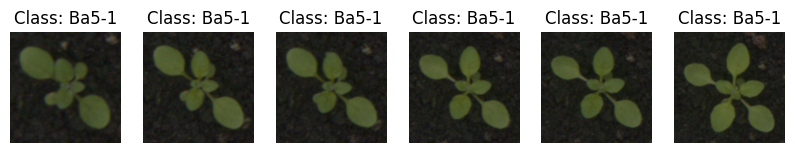

In [5]:
to_plot_from_train = 6

plt.figure(figsize=(10, 10))
for i in range(to_plot_from_train):
    plt.subplot(1, to_plot_from_train, i + 1)
    img = train_images[i].swapaxes(0,2)
    plt.imshow((img).astype(np.uint8))
    plt.title('Class: {}'.format(class_list[train_targets[i]]))
    plt.axis('off')

plt.show()

#### Dataset class and data loaders
By loading the whole dataset inside the memory, it because very easy to train the model. All we have to do is normalise the images (divide by 255 and change into C, W, H format) then return it with it's corresponding target class

- Data augmentation can be turned on/off by modifying this code (more details in comments at the end)

In [6]:
# Define whether to use data augmentation
USE_AUGMENTATION = True

# Define the dataset class for classification
class ClassificationPlantDataset(torch.utils.data.Dataset):
    def __init__(self, images, targets, transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        # Normalize image data
        image = torch.tensor(self.images[index]).type(torch.float32) / 255

        # Apply transformation if provided
        if self.transform:
            image = self.transform(image)

        target = torch.tensor(self.targets[index])
        return image, target

    def __len__(self):
        return len(self.images)

# Create train dataset
if USE_AUGMENTATION:
    train_transforms = T.Compose([
        # Data augmentation effects
        T.RandomAffine(degrees=(-180, 180), translate=(0.2, 0.2), scale=(0.8, 1.5)),
        T.RandomHorizontalFlip(),
        # T.RandomRotation([45, 270])
    ])
else:
    train_transforms = None

train_dataset = ClassificationPlantDataset(train_images, train_targets, transform=train_transforms)

# Create validation and test datasets
val_dataset = ClassificationPlantDataset(val_images, val_targets, transform=None)
test_dataset = ClassificationPlantDataset(test_images, test_targets, transform=None)

# Combine validation and test datasets
val_dataset = torch.utils.data.ConcatDataset([val_dataset, test_dataset])
test_dataset = val_dataset

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=True, drop_last=False)

print('Data loaders created')


Data loaders created


### Data sample (Run this only if you want to see an example of the data)


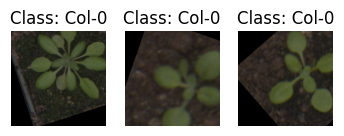

In [7]:
dataset = train_dataset

sample_size = 7
class_name = "Col-0"
img_idx = np.random.randint(0, len(dataset), size=75)
sample = [dataset[i] for i in img_idx]

plt.figure(figsize=(10, 10))
cnt = 0
for i in range(70):
    if cnt >= sample_size:
        break
    
    if class_name.lower() == class_list[sample[i][1]].lower():
        plt.subplot(1, sample_size, cnt + 1)
        img = sample[i][0].cpu().permute(1, 2, 0)
        plt.imshow((img * 255).type(torch.uint8))
        plt.title('Class: {}'.format(class_list[sample[i][1]]))
        plt.axis('off')
        cnt += 1

plt.show()

### LR Scheduler and utility functions

## Training and evaluation functions

In [8]:
def _handlezero_division_np(a,b):
    # initialize output tensor with desired value
    # c = torch.zeros_like(a)
    #c = torch.full_like(a, fill_value=float('nan'))
    # zero mask
    c = np.zeros_like(a)
    mask = (b != 0)
    # finally perform division
    c[mask] = a[mask] / b[mask]
    return c

def mathews_correlation_coefficient_np(tp, fp, fn, tn, eps=1e-11):
    tp = tp.sum().astype(np.float64)
    tn = tn.sum().astype(np.float64)
    fp = fp.sum().astype(np.float64)
    fn = fn.sum().astype(np.float64)
    _numerator = (tp*tn - fp*fn)
    _denomerator = np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    x = _numerator / (_denomerator + eps)
    # x = _handlezero_division_np(_numerator, _denomerator)
    return x

In [9]:
import pytorch_utils.callbacks as pt_callbacks

def get_callbacks(
        optimiser,
        result,
        model,
        defined_callbacks=None,
        continue_training=False,
        other_stats=None
):

    if defined_callbacks is None:
        defined_callbacks = {
            'val': pt_callbacks.Callbacks(optimizer=optimiser,
                                          model_save_path=model_save_path + 'model.pth',
                                          training_stats_path=model_save_path + 'training_stats_val',
                                          continue_training=continue_training),

            'train': pt_callbacks.Callbacks(optimizer=optimiser,
                                            training_stats_path=model_save_path + 'training_stats_train',
                                            continue_training=continue_training)
        }

    defined_callbacks['val'].reduce_lr_on_plateau(
        monitor_value=result["val_acc"],
        mode='max',
        factor=0.5,
        patience=4,
        indicator_text="Val LR scheduler: "
    )
    defined_callbacks['val'].model_checkpoint(
        model=model,
        monitor_value=result["val_acc"],
        mode='max',
        indicator_text="Val checkpoint: "
    )
    stop_flag = defined_callbacks['val'].early_stopping(
        monitor_value=result["val_acc"],
        mode='max',
        patience=20,
        indicator_text="Early stopping: "
    )
    defined_callbacks['val'].clear_memory()
    print("_________")
    return defined_callbacks, stop_flag

In [10]:
def train_loop(
        model,
        optimizer,
        epochs,
        train_loader,
        val_loader,
        model_save_folder,
        initial_lr=0.001,
        weight_decay=None,
        running_hyperopt=False,
        verbose=False,
):
    def get_result_list(history, metric):
        return [history[i][metric] for i in range(len(history))]

    # prep the model save path
    shutil.rmtree(model_save_folder, ignore_errors=True)
    os.makedirs(model_save_folder, exist_ok=True)

    # Train the model using torch
    history = pt_train.fit(
        epochs=epochs,
        lr=initial_lr,
        weight_decay=weight_decay,
        model=model,
        callbacks_function=get_callbacks,
        train_loader=train_loader,
        val_loader=val_loader,
        opt_func=optimizer,
    )

    del model

    # load the best model from checkpoint
    model = torch.load(model_save_path + "model.pth")

    train_loss_history = get_result_list(history, "train_loss")
    train_acc_history = get_result_list(history, "train_acc")
    val_loss_history = get_result_list(history, "val_loss")
    val_acc_history = get_result_list(history, "val_acc")

    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history


def evaluate_model(model, test_loader, verbose=True, eps=1e-10): 
    if verbose:
        print('--------------------------------------------')
        print('Test metrics (on test set)')

    model.eval()

    confusion_matrix = ConfusionMatrix(num_classes=len(class_list))
    eval_preds = list()
    eval_targs = list()

    # computing predictions and confusion matrix
    for i, (images, targets) in enumerate(tqdm(test_loader, position=0, leave=True)):
        images, targets = images.to(device, dtype=torch.float), torch.Tensor(targets).to(device)
        outputs = torch.nn.functional.log_softmax(model(images), dim=1)
        preds = torch.argsort(outputs, dim=1, descending=True)[:, :3]    
        eval_preds.extend(preds[:, 0].cpu().numpy())
        eval_targs.extend(targets.cpu().numpy())

    # computing main metrics (acc, precisio, recall and f1 score)
    matrix = confusion_matrix(torch.tensor(eval_preds), torch.tensor(eval_targs))
    accuracy = matrix.trace() / (matrix.sum() + eps)
    precision = np.array([matrix[i, i] / (matrix.sum(axis=0)[i] + eps) for i in range(len(class_list))])
    recall = np.array([matrix[i, i] / (matrix.sum(axis=1)[i] + eps) for i in range(len(class_list))]) 
    f1_score = 2 * precision * recall / (precision + recall + eps)

    # computing false positive rate, false negative rate, false discovery rate, false omission rate
    fp_rate = np.zeros(len(class_list))
    for idx in range(len(class_list)):
        tn = matrix.trace() - matrix[idx, idx]
        fp = np.sum([matrix[j, idx] for j in range(len(class_list)) if j != idx])
        fp_rate[idx] = fp / (fp + tn + eps)

    fn_rate = 1 - recall 
    fd_rate = 1 - precision
    specificity = 1 - fp_rate

    fo_rate = np.zeros(len(class_list))
    for idx in range(len(class_list)):  
        n = np.sum(np.array(eval_targs) != idx)
        fn = np.sum([matrix.sum(axis=0)[j] - matrix[j, j] for j in range(len(class_list)) if j != idx])
        fo_rate[idx] = fn / (n + eps)

    missclassification_rate = 1 - accuracy
    npv = 1 - fo_rate

    mcc_per_class = []
    for idx in range(len(class_list)):
        tp = matrix[idx, idx].cpu().numpy()
        tn = (matrix.trace() - matrix[idx, idx]).cpu().numpy()
        fp = np.sum([matrix[j, idx] for j in range(len(class_list)) if j != idx])
        fn = np.sum([matrix.sum(axis=0)[j] - matrix[j, j] for j in range(len(class_list)) if j != idx])
        _mcc = mathews_correlation_coefficient_np(tp, fp, fn, tn)
        mcc_per_class.append(_mcc)

    if verbose:
        print('--------------------------------------------')
        print('Accuracy: {:.3f}%'.format(accuracy * 100))
        print('Average precision: {:.3f}'.format(precision.mean()))
        print('Average recall: {:.3f}'.format(recall.mean()))
        print('Average F1 score: {:.3f}'.format(f1_score.mean()))
        print('Average specificity: {:.3f}'.format(specificity.mean()))
        print('Average false positive rate: {:3f}'.format(fp_rate.mean()))
        print('Average false negative rate: {:3f}'.format(fn_rate.mean()))
        print('Average false discovery rate: {:.3f}'.format(fd_rate.mean()))
        print('Average false omission rate: {:.3f}'.format(fo_rate.mean()))
        print('Missclassification rate: {:.2f}%'.format(missclassification_rate * 100))
        print('Mathews Correlation Coefficient: {:.2f}'.format(np.mean(mcc_per_class)))
        print('--------------------------------------------')
        print('Results by class :')    
        print('--------------------------------------------')
        print('{:<15}{:<12}{:<12}{:<12}{:<12}{:<12}{:<12}{:<12}{:<12}{:<12}{:<12}'.format('', 'Precision', 'Recall', 'F1 score', 'Specificity', 'FPR', 'FNR', 'FDR', 'FOR', 'NPV', 'MCC'))
        for idx, class_name in enumerate(class_list):
            print('{:<15}{:<12.2f}{:<12.2f}{:<12.2f}{:<12.3f}{:<12.3f}{:<12.3f}{:<12.3f}{:<12.3f}{:<12.3f}{:<12.3f}'.format(
                class_name, precision[idx], recall[idx], f1_score[idx], specificity[idx], fp_rate[idx], fn_rate[idx], fd_rate[idx], fo_rate[idx], npv[idx], mcc_per_class[idx]
            ))
        print('--------------------------------------------')
        print()

        # ploting confusion matrix
        matrix_df = pd.DataFrame(matrix.numpy(), index=class_list, columns=class_list)
        plt.figure(figsize=(12, 8))
        sn.heatmap(matrix_df, annot=True, fmt='d', cmap='Blues')

    return accuracy, precision, recall, f1_score


### Training each model
Models are loaded from torchvision.models. This library proposes multiple architectures with their weights. It is not recommended to modify these architectures. They are already defined to operate in the most optimal way possible, modifying them risks compromising a certain balance during learning. It is however possible to modify the classification part, which I do in the code by specifying the number of classes in output.

Train on correct dataset splt:


### Hyperopt for finding best combination of hyperparameters

In [11]:
# 57M parameters
class AlexNet(CustomModelBase):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
        self.model.classifier[-1] = nn.Linear(self.model.classifier[-1].in_features, num_classes, bias=True)
        
    def forward(self, x):
        return self.model(x)

# 11M paramters
class ResNet18(CustomModelBase):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes, bias=True)
        
    def forward(self, x):
        return self.model(x)

# 21M paramters
class ResNet34(CustomModelBase):
    def __init__(self, num_classes=2):
        super(ResNet34, self).__init__()
        self.model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes, bias=True)
        
    def forward(self, x):
        return self.model(x)
    
class ResNet50(CustomModelBase):
    def __init__(self, num_classes=2):
        super(ResNet50, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes, bias=True)
        
    def forward(self, x):
        return self.model(x)

# 42M paramters
class ResNet101(CustomModelBase):
    def __init__(self, num_classes=2):
        super(ResNet101, self).__init__()
        self.model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes, bias=True)
        
    def forward(self, x):
        return self.model(x)

# 6.6M paramters 
# InceptionNet v1 - GoogLeNet
class InceptionNet(CustomModelBase):
    def __init__(self, num_classes=2):
        super(InceptionNet, self).__init__()
        self.model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes, bias=True)
        
    def forward(self, x):
        return self.model(x)

# 4M parameters
class EfficientNetB0(CustomModelBase):
    def __init__(self, num_classes=2):
        super(EfficientNetB0, self).__init__()
        self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.model.classifier = nn.Linear(self.model.classifier[-1].in_features, num_classes, bias=True)
        
    def forward(self, x):
        return self.model(x)

# 6M parameters
class EfficientNetB1(CustomModelBase):
    def __init__(self, num_classes=2):
        super(EfficientNetB1, self).__init__()
        self.model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
        self.model.classifier = nn.Linear(self.model.classifier[-1].in_features, num_classes, bias=True)
        
    def forward(self, x):
        return self.model(x)

# 7.7M parameters
class EfficientNetB2(CustomModelBase):
    def __init__(self, num_classes=2):
        super(EfficientNetB2, self).__init__()
        self.model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)
        self.model.classifier = nn.Linear(self.model.classifier[-1].in_features, num_classes, bias=True)
        
    def forward(self, x):
        return self.model(x)

# 20M paramters
class EfficientNetV2_S(CustomModelBase):
    def __init__(self, num_classes=2):
        super(EfficientNetV2_S, self).__init__()
        self.model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
        self.model.classifier = nn.Linear(self.model.classifier[-1].in_features, num_classes, bias=True)
        
    def forward(self, x):
        return self.model(x)

# 27M parameters
class ConvNext_T(CustomModelBase):
    def __init__(self, num_classes=2):
        super(ConvNext_T, self).__init__()
        self.model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)
        self.model.classifier[-1] = nn.Linear(self.model.classifier[-1].in_features, num_classes, bias=True)
        
    def forward(self, x):
        return self.model(x)

# 1.5M paramters
class MobileNet_V3_Small(CustomModelBase):
    def __init__(self, num_classes=2):
        super(MobileNet_V3_Small, self).__init__()
        self.model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
        self.model.classifier[-1] = nn.Linear(self.model.classifier[-1].in_features, num_classes, bias=True)
        
    def forward(self, x):
        return self.model(x)

# 4.2M paramters
class MobileNet_V3_Large(CustomModelBase):
    def __init__(self, num_classes=2):
        super(MobileNet_V3_Large, self).__init__()
        self.model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
        self.model.classifier[-1] = nn.Linear(self.model.classifier[-1].in_features, num_classes, bias=True)
        
    def forward(self, x):
        return self.model(x)

# takes 224, 224 input shape
class ViT_B_16(CustomModelBase):
    def __init__(self, num_classes=2):
        super(ViT_B_16, self).__init__()
        self.model = models.vit_b_32(weights=None)
        self.model.heads = nn.Linear(self.model.heads[-1].in_features, num_classes)
        
    def forward(self, x):
        return self.model(x)
    
# takes 224, 224 input shape
class ViT_B_32(CustomModelBase):
    def __init__(self, num_classes=2):
        super(ViT_B_32, self).__init__()
        self.model = models.vit_b_32(weights=None)
        self.model.heads = nn.Linear(self.model.heads[-1].in_features, num_classes)
        
    def forward(self, x):
        return self.model(x)

In [12]:
def get_model_by_name(name):
    model_directory = {
        "AlexNet": AlexNet,
        "ResNet18": ResNet18,
        "ResNet34": ResNet34,
        "ResNet50": ResNet50,
        "ResNet101": ResNet101,
        "InceptionNet": InceptionNet,
        "EfficientNetB0": EfficientNetB0,
        "EfficientNetB1": EfficientNetB1,
        "EfficientNetB2": EfficientNetB2,
        "EfficientNetV2_S": EfficientNetV2_S,
        "ConvNext_T": ConvNext_T,
        "MobileNet_V3_Small": MobileNet_V3_Small,
        "MobileNet_V3_Large": MobileNet_V3_Large,
        "ViT_B_16": ViT_B_16,
        "ViT_B_32": ViT_B_32
    }
    return model_directory[name]

def get_optimizer_by_name(optim):
    if optim == 'SGD':
        optimizer = torch.optim.SGD #(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-6)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam #(model.parameters(), lr=0.02, weight_decay=1e-6)
    elif optim == 'RMSProp':
        optimizer = torch.optim.RMSprop #(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-6)
    elif optim == 'AdamW':
        optimizer = torch.optim.AdamW #(model.parameters(), lr=0.02, weight_decay=1e-6)
    return optimizer

In [13]:
def train_model(kwargs):

    print(kwargs)
    epochs = kwargs.get("epochs", EPOCHS) 

    # get model by name
    model_name = kwargs.get("model")
    model_cls = get_model_by_name(model_name)
    model = model_cls(num_classes=len(class_list)).to('cpu')

    # get optimizer
    optim_args = kwargs.get("optim")
    print(optim_args["params"])
    optimizer_cls = get_optimizer_by_name(optim_args.get("name"))
    optimizer = optimizer_cls(model.parameters(), **optim_args["params"])
    lr = optim_args["params"]["lr"]
    weight_decay = optim_args["params"]["weight_decay"]

    # model, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_loop(model, optimizer, epochs, train_loader, val_loader, verbose=True, running_hyperopt=True)
    model, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_loop(model, optimizer_cls, epochs, train_loader, val_loader, initial_lr=lr, weight_decay=weight_decay, model_save_folder=model_save_path, verbose=True, running_hyperopt=True)

    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history 

def train_model_hyperopt(kwargs):
    
    model, train_loss_history, train_acc_history, val_loss_history, val_acc_history  = train_model(kwargs)
    
    return {"loss": np.mean(val_loss_history), "status": STATUS_OK}

def unpack_values(trial):
    vals = trial["misc"]["vals"]
    # unpack the one-element lists to values
    # and skip over the 0-element lists
    rval = {}
    for k, v in list(vals.items()):
        if v:
            rval[k] = v[0]
    return rval

def export_hyperopt_log(trials):
    result_list = []
    for trial in trials.trials:
        trial_result = space_eval(search_space, unpack_values(trial))
        trial_result["val_loss"] = trial['result']['loss']
        result_list.append(trial_result)

    df_result = pd.DataFrame(result_list)
    df_result = pd.concat([df_result.drop("optim", axis=1), pd.json_normalize(df_result.optim)], axis=1)

    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = "../data/log"
    output_path = os.path.join(output_dir, f"hyperopt_result_{ts}.csv")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    df_result.to_csv(output_path, index=False)
    print(f"Exported hyperopt log to {output_path}")
    return df_result


search_space = {
    "epochs": scope.int(hp.choice("epochs", [5, 9, 13, 17, 20, 23, 26, 29, 32, 35, 37, 40, 42, 45])),
    "model": hp.choice("model_name", [
        # "AlexNet",
        # "ResNet18",
        # "ResNet34",
         "ResNet50",
         "ResNet101",
         "InceptionNet",
         "EfficientNetB0",
         "EfficientNetB1",
         "EfficientNetB2",
         "EfficientNetV2_S",
        # "ConvNext_T",
         "MobileNet_V3_Small",
         "MobileNet_V3_Large",
        # "ViT_B_16",
        # "ViT_B_32"
    ]),
    "optim": hp.choice("optim",[
        {
            "name":"Adam",
            "params": {
                "lr": hp.choice("lr-3", [1e-3, 1e-4]),
                "weight_decay": hp.choice("weight_decay-3", [3.310305423548208e-05]) 
            }
        },
    ])    
}

In [46]:
# ==========================
#  CLEAR CUDA MEMORY
# ==========================
torch.cuda.empty_cache()

# ==========================
#  ENABLE CUDA DEBUGGING
# ==========================
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.autograd.set_detect_anomaly(True)

# ==========================
#  SET DEVICE
# ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================
#  STEP 1: CHECK NUMBER OF CLASSES
# ==========================
num_classes = len(class_list)
print(f"Expected num_classes: {num_classes}")

# ==========================
#  STEP 2: CHECK DATASET LABELS
# ==========================
all_labels = []
for _, label in train_loader.dataset:
    all_labels.append(label)

all_labels = torch.tensor(all_labels)
print(f"Label range: min={all_labels.min().item()}, max={all_labels.max().item()}")

# Ensure label indices are within range
assert all_labels.max().item() < num_classes, "Error: Label index exceeds num_classes!"

# ==========================
#  STEP 3: CHECK LABEL DATA TYPE
# ==========================
for _, label in train_loader:
    assert isinstance(label, torch.Tensor), f"Error: Label is {type(label)}, expected torch.Tensor"
    assert label.dtype == torch.int64, f"Error: Found dtype {label.dtype}, expected torch.int64"

# Convert dataset labels if they are NumPy arrays
if isinstance(dataset.targets, np.ndarray):
    dataset.targets = torch.as_tensor(dataset.targets, dtype=torch.int64)  # FIXED

# ==========================
#  STEP 4: NORMALIZE DATA TO PREVENT NaN
# ==========================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# ==========================
#  STEP 5: RUN ON CPU FIRST
# ==========================
device = torch.device("cpu")
print("Running on CPU for debugging...")
model = models.efficientnet_b2(pretrained=True)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# ==========================
#  STEP 6: REDUCE BATCH SIZE (OR INCREASE FOR BATCHNORM)
# ==========================
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)  # Adjust batch size

# ==========================
#  STEP 7: TEST CUDA
# ==========================
try:
    x = torch.randn(2, 3).cuda()
    print("CUDA test passed!")
except RuntimeError as e:
    print(f"CUDA test failed: {e}")

# ==========================
#  STEP 8: MOVE MODEL TO GPU
# ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("Model moved to GPU!")

# ==========================
#  STEP 9: SET UP TRAINING
# ==========================
best_params = {
    "epochs": 1,
    "model": "EfficientNetB2",
    "optim": {
        "name": "Adam",
        "params": {"lr": 1e-5, "weight_decay": 1e-4}  # Lowered LR & increased weight decay
    }
}

scaler = GradScaler(device='cuda')  # FIXED GradScaler initialization
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params["optim"]["params"]["lr"])

# ==========================
#  STEP 10: TRAINING LOOP WITH ERROR HANDLING
# ==========================
try:
    for epoch in range(best_params["epochs"]):
        model.train()
        total_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Check if input contains NaN/Inf
            assert not torch.isnan(images).any(), "Error: Found NaN in input images!"
            assert not torch.isinf(images).any(), "Error: Found Inf in input images!"

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            # Check for NaN loss
            assert not torch.isnan(loss), "Error: Loss became NaN!"

            # Clip gradients to prevent explosion
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{best_params['epochs']}, Loss: {total_loss / len(train_loader)}")

    # Save model after training
    torch.save(model.state_dict(), "single_image.pth")
    print("Training completed successfully!")

except RuntimeError as e:
    print(f"RuntimeError encountered during training: {e}")

# ==========================
#  STEP 11: MOVE MODEL BACK TO GPU
# ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("Model moved back to GPU!")

Using device: cuda
Expected num_classes: 25


/tmp/ipykernel_954642/659036120.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(self.targets[index])


Label range: min=0, max=24
Running on CPU for debugging...
CUDA test passed!
Model moved to GPU!
Epoch 1/1, Loss: 3.198135763948614
SSSSSSSSavig
Training completed successfully!
Model moved back to GPU!


## Plot the heat map with the best model

### Grad cam and feature map visualization

In [44]:
import pytorch_utils

In [59]:
import random

matplotlib.use('Agg')

def get_all_conv_layers(model, modules_list=None, conv_layers=[], depth=0, grad_cam=False, feature_map=False):
    """
    Get all the convolutional layers of a given model
    """
    if modules_list is None:
        modules_list = list(model.modules())

    # get all the conv layers so that the last layer is used for grad cam visualisation
    if grad_cam and (not feature_map):
        for layer in modules_list:
            if isinstance(layer, torch.nn.Conv2d):
                conv_layers.append(layer)
            elif isinstance(layer, torch.nn.Sequential):
                get_all_conv_layers(model, layer, conv_layers, depth=depth + 1)

    # get all inner conv layers for feature map visualisation
    elif feature_map and (not grad_cam):
        for layer in modules_list:
            if isinstance(layer, torch.nn.Conv2d) and depth > 0:
                conv_layers.append(layer)
            elif isinstance(layer, torch.nn.Sequential) and depth > 0:
                get_all_conv_layers(model, layer, conv_layers, depth=depth + 1)

    return conv_layers


def visualise_feature_maps(feature_map, feature_map_name):
    """
    Visualise the feature maps of a given layer
    """
    feature_map = feature_map.cpu().numpy()

    # Get the number of feature maps
    num_feature_maps = feature_map.shape[1]

    # Calculate the number of rows and columns for the plot
    num_cols = 8
    num_rows = num_feature_maps // num_cols + int(num_feature_maps % num_cols > 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    plots = []
    for i in range(num_feature_maps):
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(feature_map[0, i], cmap="viridis")
        ax.axis("off")
        plots.append(feature_map[0, i])

    # Hide empty subplots
    for i in range(num_feature_maps, num_rows * num_cols):
        axes[i // num_cols, i % num_cols].axis("off")

    plt.savefig(feature_map_name)
    plt.close('all')

    # return the figure
    return plots


def normalize_feature_map(feature_map):
    min_val, max_val = np.min(feature_map), np.max(feature_map)
    return (feature_map - min_val) / (max_val - min_val)


def visualise_gradcam(images_numpy, cam, ith_image, seq_idx, i, grad_img_i_folder, max_gradcam_images=3, show_gradcam=True, class_name=""):
    """
    save GradCAMs for the given image
    """

    if show_gradcam and (i < max_gradcam_images):
        print(f"Extracting grad cam for image {i + 1}_{seq_idx}/{max_gradcam_images}")

        plt.figure(figsize=(30, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(images_numpy)
        plt.gca().set_title(class_name, fontsize=40, pad=20, y=-0.2)
        plt.axis('off')

        grayscale_cam = cam(input_tensor=ith_image, targets=None)
        grayscale_cam = grayscale_cam[0, :]
        plt.subplot(1, 3, 2)
        plt.imshow(grayscale_cam)
        plt.gca().set_title(class_name, fontsize=40, pad=20, y=-0.2)
        plt.axis('off')

        visualization = show_cam_on_image(images_numpy, grayscale_cam, use_rgb=True, image_weight=0.8)
        plt.subplot(1, 3, 3)
        plt.imshow(visualization)
        plt.gca().set_title(class_name, fontsize=40, pad=20, y=-0.2)
        plt.axis('off')

        plt.savefig(grad_img_i_folder + f"image_{seq_idx + 1}_{class_name}.png")
        plt.close('all')


def show_all_feature_maps(target_layers, model, ith_image, i, seq_index, layers_folder):
    """
    Show all the feature maps of all the target layers, of a given model, in a given image
    """

    # get feature maps for each detected target layers
    list_of_plots = {}
    valid_target_layers = []

    # Extract feature maps for each target layer and save them, if they are valid
    cnt = 0
    for j, layer in enumerate(target_layers):
        feature_maps = []

        def hook_fn(module, input, output):
            feature_maps.append(output.detach())

        # register hook to the layer to get the feature maps
        layer.register_forward_hook(hook_fn)
        model(ith_image)

        # if no feature maps were found, skip this layer
        if len(feature_maps) == 0:
            layer._forward_hooks.clear()
            continue

        if feature_maps[0].shape[-1] <=1:
            layer._forward_hooks.clear()
            continue

        print(f"Extracting feature maps for seq {i + 1}, image {seq_index}, from layer {j + 1}/{len(target_layers)}")

        # save feature maps using this function
        plots = visualise_feature_maps(feature_maps[0], f"{layers_folder}layer_{cnt + 1}.png")
        cnt += 1

        # update the list of valid target layers and the list of plots
        list_of_plots[j] = plots
        valid_target_layers.append((layer, j))  # save the layer and its index

        layer._forward_hooks.clear()

    plt.close('all')

    return list_of_plots, valid_target_layers


def create_chart(num_single_chart_layers, num_single_chart_conv_imgs, valid_target_layers, list_of_plots, layers_folder_prev, i):
    """
    Create a chart with num_single_chart_layers layers and num_single_chart_conv_imgs feature maps per layer
    """

    # select the smallest of chosen number of rows in the chart and number of valid target layers
    num_single_chart_layers = min(num_single_chart_layers, len(valid_target_layers))

    # pick num_single_chart_layers random layers without changing the order
    remove_layers_numbers = random.sample(valid_target_layers, max(len(valid_target_layers) - num_single_chart_layers, 0))
    valid_target_layers = [layer for layer in valid_target_layers if layer not in remove_layers_numbers]

    # put all layers in one image
    print(f"Merging all layers in one image...")
    plt.figure(figsize=(10 * num_single_chart_conv_imgs, 10 * num_single_chart_layers))
    cnt = 1

    # merge all feature map plots in one image to form a chart
    for j, layer in enumerate(valid_target_layers):
        layer, layer_index = layer
        plots = list_of_plots[layer_index]

        # pick num_single_chart_conv_imgs random features per layer without changing the order
        if num_single_chart_conv_imgs is not None:
            plots_numbers = [random.randint(0, len(plots) - 1) for _ in range(num_single_chart_conv_imgs)]
            plots_numbers = sorted(plots_numbers)
            plots = [plots[i] for i in plots_numbers]
        else:
            num_single_chart_conv_imgs = len(plots)

        # all plots in the selected layer
        for k, plot in enumerate(plots):
            plot = normalize_feature_map(plot)

            subplot = plt.subplot(len(valid_target_layers), num_single_chart_conv_imgs, cnt)  # (*nrows*, *ncols*, *index*)
            cnt += 1

            plt.imshow(plot, cmap="viridis")
            plt.axis('off')

            # Add "Row_j" ylabel to the first subplot of each row
            if k == 0:
                label_axis = subplot.twinx()
                label_axis.set_ylabel(f"Layer_{layer_index + 1}", fontsize=40, rotation=0, labelpad=160)
                label_axis.yaxis.set_label_position("left")
                label_axis.yaxis.tick_left()
                label_axis.yaxis.set_ticks([])
                label_axis.xaxis.set_ticks([])

    # plt.savefig(f"feature_maps{os.sep}image_{i + 1}{os.sep}Chart.png")
    plt.savefig(layers_folder_prev + f"Chart.png")
    plt.close('all')


def get_gradcam_feature_maps(model, test_loader, show_gradcam=False, max_gradcam_images=5, show_feature_map=False, max_feature_map_images=3, max_feature_map_classes=2, num_feature_map_seqs_per_class=2, num_single_chart_layers=None, num_single_chart_conv_imgs=None, class_list=class_list):
    """
    Compute GradCAM and feature maps for a given model and a given test_loader
    """

    model.eval()

    # Get all conv layers from the given model and get the last layer to visualize in GradCAM
    layers = get_all_conv_layers(model, feature_map=show_feature_map, grad_cam=show_gradcam)
    target_layers = layers.copy()
    layer = layers[-1]

    if num_single_chart_layers is None:
        num_single_chart_layers = len(target_layers)

    cam = GradCAM(model=model, target_layers=[layer], use_cuda=True)

    # create folders if they don't exist
    if show_gradcam:
        shutil.rmtree("gradcams", ignore_errors=True)
        os.makedirs("gradcams")

    if show_feature_map:
        shutil.rmtree("feature_maps", ignore_errors=True)
        os.makedirs("feature_maps")

    # computing predictions and confusion matrix
    class_seq_pairs = {}
    for i, (images, targets) in enumerate(tqdm(test_loader, position=0, leave=True)):
        # convert torch target to numpy and get the class name
        targets = targets.numpy()
        class_name = class_list[targets[0]]
        print("Class name:", class_name)
        # continue

        if show_feature_map:
            max_reached_cnt = 0
            for class_name_key in class_seq_pairs:
                if len(class_seq_pairs[class_name_key]) >= num_feature_map_seqs_per_class:
                    max_reached_cnt += 1

            # stop execution when the maximum number of classes needed is reached and all classes are filled
            if max_reached_cnt >= max_feature_map_classes:
                print(f"Max number of classes reached and filled: {max_feature_map_classes}")
                break

            # skip iteration when the maximum number of classes needed is reached, but current classes are not yet filled
            if (len(class_seq_pairs) >= max_feature_map_classes) and (class_name not in class_seq_pairs):
                # print(f"Max number of classes reached, seqs are still needed for current classes")
                continue

            # assign the class name and sequence number used within it
            if class_name not in class_seq_pairs:
                class_seq_pairs[class_name] = [i]
            else:
                # reached max number of sequences needed for this class
                if len(class_seq_pairs[class_name]) >= num_feature_map_seqs_per_class:
                    print(f"Max number of sequences reached for class {class_name}: {num_feature_map_seqs_per_class}")
                    continue
                class_seq_pairs[class_name].append(i)

        # for grad cams and feature maps create a separate folder for each image
        if show_gradcam and i < max_gradcam_images:
            grad_img_i_folder = f"gradcams{os.sep}seq_{i + 1}{os.sep}"
            shutil.rmtree(grad_img_i_folder, ignore_errors=True)
            os.makedirs(grad_img_i_folder)

        print(f"images shape", images.shape)

        images, targets = images.to(device, dtype=torch.float), torch.Tensor(targets).to(device)
        org_images = images[0]  # we assume that batch size is 1, since it is designed to run on test loader

        random_seq_idx = random.randint(0, images.shape[2] - 1 - max_feature_map_images)
        num_feature_map_image_cnt = 0
        for seq_idx in range(images.shape[2]):
            if show_feature_map:
                # we need 4 random consecutive images from the same sequence
                if seq_idx < random_seq_idx:
                    continue

            # clear memory
            gc.collect()
            torch.cuda.empty_cache()

            # Get the ith image from the sequence
            ith_image = org_images.permute(1, 0, 2, 3)  # ([3, 32, 128, 128]) to ([32, 3, 128, 128])
            ith_image = ith_image[seq_idx:seq_idx + 1].clone()  # Create a new tensor to avoid modifying the original one

            # No need to convert back to tensor since it's already a tensor
            ith_image = ith_image.to(device, dtype=torch.float)
            outputs = torch.nn.functional.log_softmax(model(ith_image), dim=1)
            preds = torch.argsort(outputs, dim=1, descending=True)[:, :3]

            # get numpy array from images
            images_numpy = ith_image.cpu().numpy()
            images_numpy = np.transpose(images_numpy, (0, 2, 3, 1))
            images_numpy = np.squeeze(images_numpy)

            # show GradCAMs for the max given images
            if show_gradcam and (i < max_gradcam_images):
                visualise_gradcam(
                    images_numpy=images_numpy,
                    cam=cam,
                    ith_image=ith_image,
                    seq_idx=seq_idx,
                    i=i,
                    max_gradcam_images=max_gradcam_images,
                    show_gradcam=show_gradcam,
                    grad_img_i_folder=grad_img_i_folder,
                    class_name=class_name,
                )

            # show feature maps for the max given images
            if show_feature_map:
                # create folder for each image/sequence and delete the previous one
                layers_folder = f"feature_maps{os.sep}class_{class_name}{os.sep}seq_{len(class_seq_pairs[class_name])}{os.sep}image_{seq_idx + 1}{os.sep}layers{os.sep}"
                layers_folder_prev = layers_folder.replace("layers" + os.sep, "")
                shutil.rmtree(layers_folder_prev, ignore_errors=True)
                os.makedirs(layers_folder, exist_ok=True)

                # get feature maps for all layers
                list_of_plots, valid_target_layers = show_all_feature_maps(
                    target_layers=target_layers,
                    model=model,
                    ith_image=ith_image,
                    i=i,
                    seq_index=seq_idx + 1,
                    layers_folder=layers_folder
                )

                # create chart for all layers of the current image
                create_chart(
                    num_single_chart_layers=num_single_chart_layers,
                    num_single_chart_conv_imgs=num_single_chart_conv_imgs,
                    valid_target_layers=valid_target_layers,
                    list_of_plots=list_of_plots,
                    layers_folder_prev=layers_folder_prev,
                    i=i
                )

                num_feature_map_image_cnt += 1

                print(f"\nFeature maps and chart for sequence {i + 1}, image {seq_idx + 1} saved successfully!\n\n")
                if num_feature_map_image_cnt >= max_feature_map_images and show_feature_map:
                    print(f"Max number of feature map images reached: {max_feature_map_images}")
                    break

        # stop after max images
        if ((i >= max_gradcam_images) and show_gradcam):
            break

    print("\nMaximum selected sequences completed!\n")

In [2]:
# from pytorch_utils.visualization_utils import *
# Define Constants
MODELS_FOLDER_NAME = "vis_models" + os.sep  # Folder for model (.pth) files
MAX_GRADCAM_IMAGES = 6000  # Max images for GradCAM
MAX_FEATURE_MAP_CLASSES = 100  # Max classes for feature maps
MAX_FEATURE_MAP_IMAGES_PER_CLASS = 1  # Max images per class for feature maps

NUM_SINGLE_CHART_CONV_IMGS = 5  # Number of features displayed per column in "feature maps chart"
NUM_SINGLE_CHART_LAYERS = 20  # Number of CNN layers displayed as rows in "feature maps chart"

ENABLE_GRADCAM = True  # Toggle GradCAM visualization
ENABLE_FEATURE_MAPS = True  # Toggle feature maps visualization

# Ensure the models folder exists
os.makedirs(MODELS_FOLDER_NAME, exist_ok=True)

# Get list of models in the folder
models_list = os.listdir(MODELS_FOLDER_NAME)

if not models_list:
    raise FileNotFoundError(
        f"No model files found in {MODELS_FOLDER_NAME}! Please add model files and rerun."
    )

# Display available models and let user choose one
print("Models available:")
for i, model_name in enumerate(models_list, start=1):
    print(f"{i}: {model_name}")

try:
    ch = int(input("\nChoose model (enter number): "))
    if ch < 1 or ch > len(models_list):
        raise ValueError("Invalid choice. Please select a valid model number.")
except ValueError as e:
    raise ValueError("Invalid input. Please enter a number.") from e

model_path = os.path.join(MODELS_FOLDER_NAME, models_list[ch - 1])

# Free GPU memory
gc.collect()
torch.cuda.empty_cache()

# Load model
model = torch.load(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu")
# model.eval()

# Perform GradCAM and Feature Map extraction based on flags
if ENABLE_GRADCAM or ENABLE_FEATURE_MAPS:
    get_gradcam_feature_maps(
        model=model,
        test_loader=test_loader,
        class_list=class_list,
        device=device,
        show_gradcam=ENABLE_GRADCAM,
        show_feature_map=ENABLE_FEATURE_MAPS,
        max_gradcam_images=MAX_GRADCAM_IMAGES,
        feature_map_max_classes=MAX_FEATURE_MAP_CLASSES,
        feature_map_max_images_per_class=MAX_FEATURE_MAP_IMAGES_PER_CLASS,
        num_single_chart_conv_imgs=NUM_SINGLE_CHART_CONV_IMGS,
        num_single_chart_layers=NUM_SINGLE_CHART_LAYERS,
    )

print("Processing complete.")

In [54]:
# Ensure matplotlib backend is correctly set
print("Current backend:", matplotlib.get_backend())

# Constants
SAMPLE_SIZE = 120  # Ensure it's a multiple of 5
BATCH_SIZE = 1     # Single image per batch
FIGURE_SIZE = (16, 16)

# DataLoader
loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Clear previous figures and free up GPU memory
plt.close("all")
gc.collect()
torch.cuda.empty_cache()

# Initialize Saliency method on the model
saliency = Saliency(best_model)  # Use `best_model`, assumed to be loaded

# Define custom colormap for visualization
default_cmap = LinearSegmentedColormap.from_list(
    'custom_blue',
    [(0, '#ffffff'), (0.5, '#000000'), (1, '#000000')],
    N=256
)

# Visualization loop
row_entry = 0
fig, axes = plt.subplots(1, 10, figsize=FIGURE_SIZE)

for i, (images, labels) in enumerate(loader):
    if i == SAMPLE_SIZE:
        break

    if row_entry % 5 == 0:
        plt.close(fig)  # Close previous figure to free memory
        fig, axes = plt.subplots(1, 10, figsize=FIGURE_SIZE)  # Create new figure every 5 samples
        row_entry = 0

    row_entry += 1

    # Compute Saliency Maps
    attributions_saliency = saliency.attribute(images.cuda(), target=labels.type(torch.int64).cuda())

    # Convert tensors to NumPy arrays
    attr_np = np.transpose(attributions_saliency.squeeze().cpu().detach().numpy(), (1, 2, 0))
    img_np = np.transpose(images.squeeze().cpu().detach().numpy(), (1, 2, 0))
    
    # Get class name for visualization
    class_name = class_list[labels.item()]

    # Plot Original Image
    _ = viz.visualize_image_attr(
        attr_np, img_np, method="original_image", sign='positive',
        fig_size=(4, 3), plt_fig_axis=(fig, axes[row_entry * 2 - 2]),
        use_pyplot=False
    )
    axes[row_entry * 2 - 2].set_title(class_name, y=-0.25)  # Set class name below the image

    # Plot Saliency Heatmap
    _ = viz.visualize_image_attr(
        attr_np, img_np, method="heat_map", sign='positive',
        cmap=default_cmap, fig_size=(4, 3), show_colorbar=True,
        plt_fig_axis=(fig, axes[row_entry * 2 - 1]),
        use_pyplot=False
    )

plt.show()

Current backend: module://matplotlib_inline.backend_inline


NameError: name 'best_model' is not defined